In [9]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!pip install pvlib

# 1. Imports

In [11]:
from pvlib.pvsystem import retrieve_sam, PVSystem
import pvlib
import pandas as pd
from pvlib.pvsystem import PVSystem
from pvlib.modelchain import ModelChain
from pvlib.location import Location
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from math import ceil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from numpy import random

# 2. Charger les données météo

In [12]:
# Lecture du fichier CSV contenant les données météorologiques, en ignorant les 2 premières lignes :
weather = pd.read_csv("/content/drive/MyDrive/models/weather_data.csv", skiprows=2)

# Création d'une colonne datetime à partir des colonnes année, mois, jour, heure, minute :
weather['Datetime'] = pd.to_datetime(weather[['Year', 'Month', 'Day', 'Hour', 'Minute']])

# Construction d’un DataFrame PVLib avec les colonnes nécessaires (irradiance, température, vitesse du vent) :
weather['timestamp'] = pd.to_datetime({
    'year': 2022,  # Force all data into one "typical" year
    'month': weather['Month'],
    'day': weather['Day'],
    'hour': weather['Hour'],
    'minute': weather['Minute']
})

weather.set_index('timestamp', inplace=True) # Mise en place du Dataframe

df_weather = pd.DataFrame({
   'ghi': weather['GHI'],                       # Global Horizontal Irradiance
    'dni': weather['DNI'],                      # Direct Normal Irradiance
    'dhi': weather['DHI'],                      # Diffuse Horizontal Irradiance
    'temp_air': weather['Temperature'],         # température
    'wind_speed': weather['Wind Speed']         # vitesse du vent
}, index=weather.index)

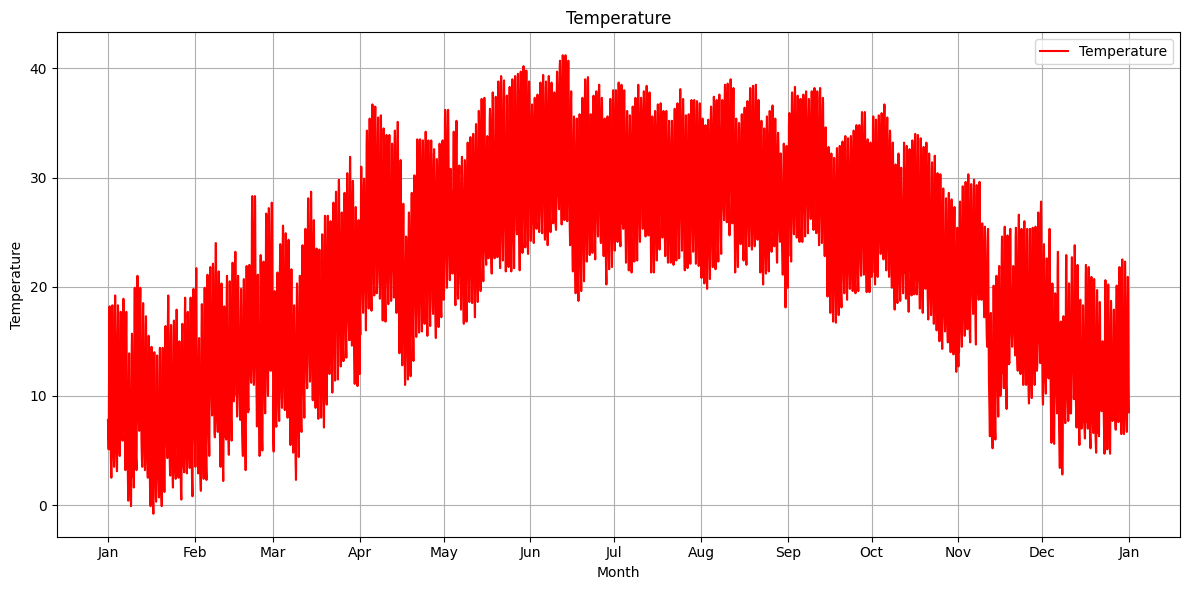

In [13]:
plt.figure(figsize=(12, 6))  # Définir la taille de la figure

# Tracer la température en fonction du temps :
plt.plot(df_weather['temp_air'].index, df_weather['temp_air'].values, label='Temperature', color='red')

# Mise en forme de l’axe des x : affichage par mois :
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Jan, Feb, etc.

plt.xlabel('Month')
plt.ylabel('Temperature')
plt.title('Temperature')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

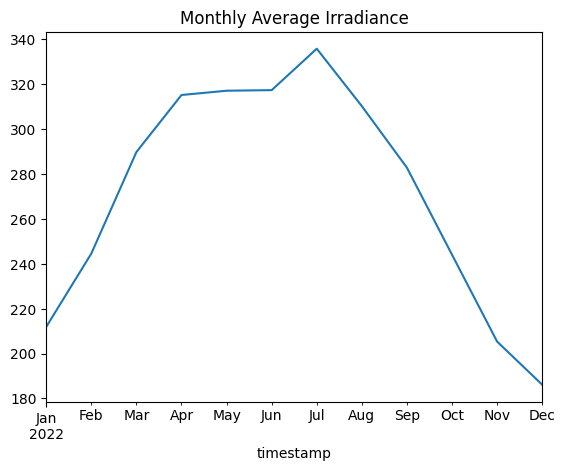

In [14]:
#L'irradiance moyenne par mois
monthly_irradiance = df_weather['ghi'].resample('ME').mean()
monthly_irradiance.plot(title='Monthly Average Irradiance')
plt.show()

# 3. Charger la production cible et les charges depuis le fichier Excel

In [15]:
df_excel = pd.read_excel("/content/drive/MyDrive/models/Production PV prévue et le Gain Gazoil pou le projet BEH 1MWc hybrid (2).xlsx", sheet_name="Bordj El Houas",nrows=288)

# Supprimer les espaces vides avant/après les noms de colonnes.
df_excel.columns = df_excel.columns.str.strip()

# Initialisation d’un dictionnaire pour stocker les données finales (Date + charge)
df_c={
    "Date":[],
    "charge":[]
}

# Nombre de jours par mois pour une année :
months=[31,28,31,30,31,30,31,31,30,31,30,31]
year=2022  # Année cible de la simulation

for i,mounth in enumerate(months):      # Boucle sur chaque mois de l’année :
    dfx=df_excel.iloc[24*i:24*(i+1)]    # Extraction d’un jour type (24h) pour ce mois
    for day in range(1,mounth+1):       # Répétition du jour type pour chaque jour du mois
        for ho in range(24):
              # Ajout d’une petite variation aléatoire à la charge :
            charge_avec_variation = dfx.iloc[ho]["Charge"] + random.randint(0.2 * dfx.iloc[ho]["Charge"])
            df_c["charge"].append(charge_avec_variation)

            # Création du timestamp correspondant à cette heure (à HH:30)
            date = datetime(year, i+1, day, ho, 30, 0)
            df_c["Date"].append(date)

df_charge = pd.DataFrame(df_c)
df_charge.to_excel("charges.xlsx",index=False)
df_charge.set_index('Date', inplace=True)

df_charge

,charge
Date,
2022-01-01 00:30:00,1484
2022-01-01 01:30:00,1252
2022-01-01 02:30:00,1225
2022-01-01 03:30:00,1170
2022-01-01 04:30:00,1228
...,...
2022-12-31 19:30:00,1582
2022-12-31 20:30:00,1640
2022-12-31 21:30:00,1729


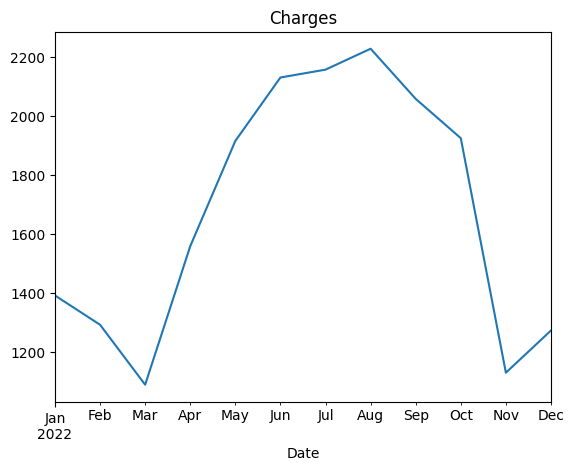

In [16]:
charges = df_charge['charge'].resample('ME').mean()
charges.plot(title='Charges')
plt.show()

# 4. Définir les paramétres des components

## 4.1 Les panneaux

In [17]:
# On importe les modules CEC (California Energy Commission) de la base de données SAM fournie par pvlib :
sandia_modules = pvlib.pvsystem.retrieve_sam('cecmod')
sandia_modules.keys()

retrieve_sam('cecmod')    # renvoie un DataFrame pandas contenant les caractéristiques techniques de nombreux panneaux photovoltaïques.
sandia_modules.keys()     # renvoie une liste des noms de modules (chaînes de caractères), chacun correspondant à un modèle particulier.

Index(['A10Green_Technology_A10J_S72_175', 'A10Green_Technology_A10J_S72_180',
       'A10Green_Technology_A10J_S72_185', 'A10Green_Technology_A10J_M60_220',
       'A10Green_Technology_A10J_M60_225', 'A10Green_Technology_A10J_M60_230',
       'A10Green_Technology_A10J_M60_235', 'A10Green_Technology_A10J_M60_240',
       'A2Peak_Power_POWER_ON_P220_6x10', 'Aavid_Solar_ASMS_165P',
       ...
       'Zytech_Solar_ZT275P', 'Zytech_Solar_ZT280P', 'Zytech_Solar_ZT285P',
       'Zytech_Solar_ZT290P', 'Zytech_Solar_ZT295P', 'Zytech_Solar_ZT300P',
       'Zytech_Solar_ZT305P', 'Zytech_Solar_ZT310P', 'Zytech_Solar_ZT315P',
       'Zytech_Solar_ZT320P'],
      dtype='object', length=21535)

In [18]:
# On crée une liste vide pour stocker les noms des modules qui correspondent à notre recherche :
md_l=[]

# On parcourtant tous les noms de modules disponibles dans la base de données :
for x in sandia_modules.keys():

    # On vérifie si le nom "yl250p_29b" est contenu dans le nom du module actuel :
    if "yl250p_29b".lower() in x.lower():

        # Si c'est le cas, on ajoute ce nom de module à la liste :
        md_l.append(x)

# On affiche les noms de modules trouvés :
for x in md_l:
    print(x)

Yingli_Energy__China__YL250P_29b


In [19]:
# # On sélectionne le premier module trouvé dans la liste md_l :
module=sandia_modules[md_l[0]]
# # On affiche toutes les caractéristiques du module sélectionné :
module

# Technology	Technologie de cellule : ici "Multi-c-Si" signifie silicium multicristallin.
# Bifacial	0 = panneau non bifacial (ne capte pas la lumière des deux côtés).
# STC	        Puissance maximale (en watts) aux conditions standards STC (1000 W/m², 25°C).
# PTC	        Puissance estimée aux conditions PTC (plus proches du réel), ici 226.2 W.
# A_c	        Surface du panneau en m² (ici 1.634 m²).
# Length	    Longueur du panneau (en mètres).
# Width	        Largeur du panneau (en mètres).
# N_s	        Nombre de cellules en série.

# 🔌 Caractéristiques électriques :
# I_sc_ref	    Courant de court-circuit (A) à STC.
# V_oc_ref	    Tension en circuit ouvert (V) à STC.
# I_mp_ref	    Courant au point de puissance maximale (A).
# V_mp_ref	    Tension au point de puissance maximale (V).
# alpha_sc	    Coefficient de température du courant de court-circuit (A/°C).
# beta_oc	    Coefficient de température de la tension en circuit ouvert (V/°C).

# 🌡️ Modélisation thermique et paramètres du modèle PV :
# T_NOCT	    Température nominale de fonctionnement (NOCT) en °C, généralement mesurée à 800 W/m².
# a_ref	        Paramètre du modèle de diode PV (utilisé dans le modèle à une diode).
# I_L_ref	    Courant généré par la lumière à STC (A).
# I_o_ref	    Courant de saturation de la diode (en général très faible, ici 0).
# R_s	        Résistance série du module (Ω), limite le courant.
# R_sh_ref	    Résistance de shunt (Ω), influence les pertes par fuite de courant.
# Adjust	    Coefficient d’ajustement utilisé par SAM pour améliorer la précision du modèle.
# gamma_r	    Coefficient de température de la puissance (en %/°C, ici -0.4586 %/°C).





,Yingli_Energy__China__YL250P_29b
Technology,Multi-c-Si
Bifacial,0
STC,250.496
PTC,226.2
A_c,1.634
Length,1.65
Width,0.99
N_s,60
I_sc_ref,8.79
V_oc_ref,38.4


## 4.2 Onduleurs

In [20]:
# On récupère la base de données des onduleurs CEC via la fonction retrieve_sam de pvlib :
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

# On affiche toutes les clés (noms des onduleurs) présentes dans cette base de données
cec_inverters.keys()

Index(['ABB__MICRO_0_25_I_OUTD_US_208__208V_',
       'ABB__MICRO_0_25_I_OUTD_US_240__240V_',
       'ABB__MICRO_0_3_I_OUTD_US_208__208V_',
       'ABB__MICRO_0_3_I_OUTD_US_240__240V_',
       'ABB__MICRO_0_3HV_I_OUTD_US_208__208V_',
       'ABB__MICRO_0_3HV_I_OUTD_US_240__240V_',
       'ABB__PVI_10_0_I_OUTD_x_US_208_y__208V_',
       'ABB__PVI_10_0_I_OUTD_x_US_480_y_z__480V_',
       'ABB__PVI_12_0_I_OUTD_x_US_480_y__480V_',
       'ABB__PVI_3_0_OUTD_S_US__208V_',
       ...
       'Zigor__Sunzet_3_TL_US__240V_', 'i_Energy__GT260__240V_',
       'iPower__SHO_1_1__120V_', 'iPower__SHO_2_0__240V_',
       'iPower__SHO_2_5__240V_', 'iPower__SHO_3_0__240V_',
       'iPower__SHO_3_5__240V_', 'iPower__SHO_4_6__208V_',
       'iPower__SHO_4_8__240V_', 'iPower__SHO_5_2__240V_'],
      dtype='object', length=3264)

In [21]:
in_l=[]
for x in cec_inverters.keys():  # Pour chaque nom d'onduleur dans la base de données

    # Si la chaîne "Sungrow_Power_Supply_Co___Ltd___" est contenue dans le nom :
    if "Sungrow_Power_Supply_Co___Ltd___".lower() in x.lower():
        in_l.append(x) # On ajoute ce nom à la liste in_l
for x in in_l:
    print(x)

Sungrow_Power_Supply_Co___Ltd___SC1000KU__540V_
Sungrow_Power_Supply_Co___Ltd___SC250KU__480V_
Sungrow_Power_Supply_Co___Ltd___SG_60KU_M__480V_
Sungrow_Power_Supply_Co___Ltd___SG1000MX
Sungrow_Power_Supply_Co___Ltd___SG100KU__480V_
Sungrow_Power_Supply_Co___Ltd___SG100KU_outdoor__480V_
Sungrow_Power_Supply_Co___Ltd___SG125HV__600V_
Sungrow_Power_Supply_Co___Ltd___SG2500U__550V_
Sungrow_Power_Supply_Co___Ltd___SG250KC__600V_
Sungrow_Power_Supply_Co___Ltd___SG250KU__480V_
Sungrow_Power_Supply_Co___Ltd___SG30KU
Sungrow_Power_Supply_Co___Ltd___SG36KU
Sungrow_Power_Supply_Co___Ltd___SG500LV
Sungrow_Power_Supply_Co___Ltd___SG60KU
Sungrow_Power_Supply_Co___Ltd___SG60KU_M
Sungrow_Power_Supply_Co___Ltd___SG750MX
Sungrow_Power_Supply_Co___Ltd___SG800MX


In [22]:
# On sélectionne un onduleur spécifique, ici le 4ème (indice 3) dans la liste filtrée :
inverter=cec_inverters[in_l[3]]


# # Tension alternative en sortie de l'onduleur (Vac), en volts
# Vac = 0

# # Puissance DC à laquelle l’onduleur atteint son efficacité maximale (Pso), en watts
# Pso = 7066.063965

# # Puissance AC nominale de sortie (Paco), en watts
# Paco = 1000000.0

# # Puissance DC maximale que l’onduleur peut convertir (Pdco), en watts
# Pdco = 1033038.5

# # Tension DC à laquelle Pdco est déterminée (Vdco), en volts
# Vdco = 630.0

# # Coefficients empiriques du modèle CEC (pertes statiques)
# C0 = -0.0       # Terme constant de pertes (souvent nul ou très faible)
# C1 = 0.000021   # Pertes proportionnelles au courant DC
# C2 = 0.001095   # Pertes quadratiques en courant DC
# C3 = 0.001191   # Pertes dépendantes de la tension DC

# # Pnt : Puissance AC consommée par l'onduleur à vide (nuit), en watts
# Pnt = 300.0

# # Vdcmax : Tension DC maximale admissible par l'onduleur, en volts
# Vdcmax = 800.0

# # Idcmax : Courant DC maximum admissible, en ampères
# Idcmax = 1639.743651

# # Plage de fonctionnement du MPPT (algorithme de suivi du point de puissance maximale)
# Mppt_low = 570.0   # Tension DC minimale pour le suivi MPPT
# Mppt_high = 800.0  # Tension DC maximale pour le suivi MPPT

# # Date de certification CEC
# CEC_Date = '2/1/2019'

# # Type d'onduleur selon la classification CEC
# CEC_Type = 'Utility Interactive'
inverter['Pnt']=0.0
inverter['Pdco']=inverter['Paco']/0.98
inverter['Vdco']=630.0
inverter['Vdcmax']=1000.0
inverter['Idcmax']=inverter['Pdco']/inverter['Vdco']
inverter['Mppt_low']=550.0
inverter['Mppt_high']=850.0
print(inverter)



Vac                            0
Pso                  7066.063965
Paco                   1000000.0
Pdco              1020408.163265
Vdco                       630.0
C0                          -0.0
C1                      0.000021
C2                      0.001095
C3                      0.001191
Pnt                          0.0
Vdcmax                    1000.0
Idcmax               1619.695497
Mppt_low                   550.0
Mppt_high                  850.0
CEC_Date                2/1/2019
CEC_Type     Utility Interactive
Name: Sungrow_Power_Supply_Co___Ltd___SG1000MX, dtype: object


# 5. Localisation et système PV

In [23]:
latitude = 24.49
longitude = 9.46

In [24]:
site = Location(latitude=latitude, longitude=longitude, tz='Africa/Algiers', altitude=1083, name='Bordj El Houas')

temperature_model = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']



# 6. Dimensionnement: Système PV raccordé au reseaux

## 6.1 Algorithme

In [25]:
# Calcul du nombre maximum de modules que peut supporter un onduleur en fonction de sa puissance AC nominale (Pdco)
# Hypothèse : chaque module fournit environ 250 W
max_module_per_inverter=inverter['Pdco']//250

# Calcul du nombre maximum de strings possibles par onduleur
# Hypothèse : 20 modules par string → on divise le total de modules admissibles par 20
max_strings_per_inverter=max_module_per_inverter//20

# Création d’un système PV avec les paramètres spécifiés
full_system = PVSystem(
    surface_tilt=latitude,
    surface_azimuth=180,
    module_parameters=module,
    temperature_model_parameters=temperature_model,
    inverter_parameters=inverter,
    modules_per_string=20,
    strings_per_inverter=max_strings_per_inverter
)

# Initialisation d’un modèle de simulation de production basé sur ce système complet
# 'no_loss' : on suppose ici qu’il n’y a pas de perte d’angle d'incidence (AOI), simplification
max_mc = ModelChain(full_system, site, aoi_model='no_loss')


# Affiche le nombre maximum de strings par onduleur
# Cela permet de dimensionner correctement le champ PV sans dépasser la capacité de l’onduleur
max_strings_per_inverter


204.0

In [26]:
number_inverters=1

nb_days=365
all_full_prod={}
for hour in df_charge.index[24*0:24*(nb_days+1)]:


    #load charges data and weather data at idx time
    dfc=df_charge.loc[[hour]]
    dfw=df_weather.loc[[hour]]

    p_cons=dfc["charge"][hour]
    ghi=dfw["ghi"][hour]

    #full inverter
    max_mc.run_model(dfw)
    max_ac_values=max_mc.results.ac

    full_inverter_p_prod=max_ac_values.sum()/1000
    all_full_prod[hour]=full_inverter_p_prod




In [27]:
def energy_deficit(number_inverters,strings_per_inverter,stop):
  nb_days=365
  all_energie_non_fourne={}
  all_energie_fourne={}
  all_pcons={}
  for hour in df_charge.index[24*0:24*(nb_days+1)]:
      #load charges data and weather data at idx time
      dfc=df_charge.loc[[hour]]
      dfw=df_weather.loc[[hour]]

      p_cons=dfc["charge"][hour]
      ghi=dfw["ghi"][hour]


      full_inverter_p_prod=all_full_prod[hour]
      p_prod=full_inverter_p_prod*strings_per_inverter/max_strings_per_inverter + full_inverter_p_prod*(number_inverters-1)
      all_energie_fourne[hour]=p_prod

      if ghi>=200:
        all_energie_non_fourne[hour]=max(p_cons-p_prod,0)
        all_pcons[hour]=p_cons
      if hour==stop:
        break
  return all_energie_non_fourne,all_energie_fourne,all_pcons

In [28]:
all_pcons_day={}


for hour in df_charge.index[24*0:24*(nb_days+1)]:


    #load charges data and weather data at idx time
    dfc=df_charge.loc[[hour]]
    dfw=df_weather.loc[[hour]]

    p_cons=dfc["charge"][hour]
    ghi=dfw["ghi"][hour]

    if ghi>=200:
      all_pcons_day[hour]=p_cons

print(np.sum(list(all_pcons_day.values())))

6265649


In [29]:
#target_lpsp=0.3
saved_number_inverters=0
saved_strings_per_inverter=0
list_target=np.arange(0.35,0.39,0.05)
for ipos,target_lpsp in enumerate(list_target):

  number_inverters=1
  pas=51
  strings_per_inverter=pas

  #saved_number_inverters=1

  #saved_number_inverters=number_inverters
  #saved_strings_per_inverter=strings_per_inverter

  nb_days=365
  all_pcons={}

  all_energie_non_fourne={}

  print(target_lpsp)
  completer=False
  for hour in df_charge.index[24*0:24*(nb_days+1)]:


      #load charges data and weather data at idx time
      dfc=df_charge.loc[[hour]]
      dfw=df_weather.loc[[hour]]

      p_cons=dfc["charge"][hour]
      ghi=dfw["ghi"][hour]


      full_inverter_p_prod=all_full_prod[hour]
      p_prod=full_inverter_p_prod*strings_per_inverter/max_strings_per_inverter + full_inverter_p_prod*(number_inverters-1)

      if p_prod<p_cons and hour.hour!=17:
        if ghi>=200:
          all_energie_non_fourne[hour]=max(p_cons-p_prod,0)
          all_pcons[hour]=p_cons

          lpsp=np.sum(list(all_energie_non_fourne.values()))/np.sum(list(all_pcons.values()))



          if lpsp>target_lpsp:

            strings_per_inverter+=pas
            if strings_per_inverter>max_strings_per_inverter:
              strings_per_inverter=pas
              number_inverters+=1
            print("    ",hour,"--->  lpsp:",lpsp,"   nb:",number_inverters," st:",strings_per_inverter,full_inverter_p_prod)
            all_energie_non_fourne,_,_=energy_deficit(number_inverters,strings_per_inverter,hour)
            vc=(strings_per_inverter/max_strings_per_inverter+number_inverters-1)*np.sum(list(all_full_prod.values()))
            print("    ",vc,np.sum(list(all_pcons_day.values())),number_inverters,strings_per_inverter)
            if vc-np.sum(list(all_pcons_day.values()))>=1*100000000:
              print("    ",vc,np.sum(list(all_pcons_day.values())))
              break



  vc=(strings_per_inverter/max_strings_per_inverter+number_inverters-1)*np.sum(list(all_full_prod.values()))
  if vc-np.sum(list(all_pcons_day.values()))<0:
    print(ipos-1,list_target[ipos-1],number_inverters,strings_per_inverter)
    break

  saved_strings_per_inverter=strings_per_inverter
  saved_number_inverters=number_inverters

strings_per_inverter=saved_strings_per_inverter
number_inverters=saved_number_inverters

0.35
     2022-01-01 08:30:00 --->  lpsp: 0.9060698762070921    nb: 1  st: 102 578.233842069141
     1139323.7078532216 6265649 1 102
     2022-01-01 09:30:00 --->  lpsp: 0.7710633753439774    nb: 1  st: 153 810.4957230942917
     1708985.5617798325 6265649 1 153
     2022-01-01 10:30:00 --->  lpsp: 0.621653410192105    nb: 1  st: 204 936.3363447360182
     2278647.415706443 6265649 1 204
     2022-01-01 11:30:00 --->  lpsp: 0.4539010270559357    nb: 2  st: 51 978.286777439194
     2848309.269633054 6265649 2 51
     2022-04-30 15:30:00 --->  lpsp: 0.3503644386740234    nb: 2  st: 102 494.1373077087607
     3417971.123559665 6265649 2 102
     2022-05-17 15:30:00 --->  lpsp: 0.350411173479043    nb: 2  st: 153 428.6578228889755
     3987632.9774862756 6265649 2 153
     2022-06-11 12:30:00 --->  lpsp: 0.3501502871962765    nb: 2  st: 204 747.716012150552
     4557294.831412886 6265649 2 204
     2022-07-09 08:30:00 --->  lpsp: 0.35001646375124124    nb: 3  st: 51 521.6328485775335
    

In [30]:
all_energie_non_fourne,all_energie_fourne,all_pcons=energy_deficit(number_inverters,strings_per_inverter,df_charge.index[-1])
print(df_charge.index[-1],number_inverters,strings_per_inverter)
print(all_energie_fourne)
print(np.sum(list(all_energie_non_fourne.values())),np.sum(list(all_energie_fourne.values())),np.sum(list(all_pcons.values())))

2022-12-31 23:30:00 0 0
{Timestamp('2022-01-01 00:30:00'): np.float64(0.0), Timestamp('2022-01-01 01:30:00'): np.float64(0.0), Timestamp('2022-01-01 02:30:00'): np.float64(0.0), Timestamp('2022-01-01 03:30:00'): np.float64(0.0), Timestamp('2022-01-01 04:30:00'): np.float64(0.0), Timestamp('2022-01-01 05:30:00'): np.float64(0.0), Timestamp('2022-01-01 06:30:00'): np.float64(0.0), Timestamp('2022-01-01 07:30:00'): np.float64(-125.81719507105095), Timestamp('2022-01-01 08:30:00'): np.float64(-578.233842069141), Timestamp('2022-01-01 09:30:00'): np.float64(-810.4957230942917), Timestamp('2022-01-01 10:30:00'): np.float64(-936.3363447360182), Timestamp('2022-01-01 11:30:00'): np.float64(-978.286777439194), Timestamp('2022-01-01 12:30:00'): np.float64(-954.5160844904892), Timestamp('2022-01-01 13:30:00'): np.float64(-870.960261153911), Timestamp('2022-01-01 14:30:00'): np.float64(-729.7297893097665), Timestamp('2022-01-01 15:30:00'): np.float64(-535.058974787553), Timestamp('2022-01-01 16:30

## 6.2 Affichage des résultats du Dimensionnement

In [31]:
#nb inverter results
print("NB Inverters:",number_inverters)
print("strings Per last Inverter:",strings_per_inverter)
print("modules Per lastInverter:",strings_per_inverter*20)

nb_modules=strings_per_inverter*20+max_strings_per_inverter*20*(number_inverters-1)
print("All-modules connected to all inverters:",nb_modules)
print()
print()

NB Inverters: 0
strings Per last Inverter: 0
modules Per lastInverter: 0
All-modules connected to all inverters: -4080.0




## 6.3 Simulation du Système

In [32]:
all_to_grid={}
all_from_grid={}

all_pprod_grid={}

all_pcons={}
all_pcons_day={}
all_pprod={}
nb_days=365


for hour in df_charge.index[24*0:24*(nb_days)]:

    #load charges data and weather data at idx time
    dfc=df_charge.loc[[hour]]
    dfw=df_weather.loc[[hour]]

    p_cons=dfc["charge"][hour]
    ghi=dfw["ghi"][hour]

    #full inverter
    full_inverter_p_prod=all_full_prod[hour]
    p_prod=full_inverter_p_prod*strings_per_inverter/max_strings_per_inverter + full_inverter_p_prod*(number_inverters-1)





    all_pprod[hour]=p_prod
    all_pprod_grid[hour]=p_prod

    if ghi >= 200 :
      all_pcons_day[hour]=p_cons
    else:
      all_pcons_day[hour]=0


    if p_cons>p_prod:
        besoin=p_cons-p_prod
        all_from_grid[hour]=besoin
        p_prod=p_cons
        all_pprod_grid[hour]=p_prod

    all_pcons[hour]=p_cons
    all_to_grid[hour]=p_prod-p_cons

## 6.4 Verfication des résultas de la simulation

In [33]:
print("NB Inverters:",number_inverters)
print("strings Per last Inverter:",strings_per_inverter)
print("modules Per lastInverter:",strings_per_inverter*20)

nb_modules=strings_per_inverter*20+max_strings_per_inverter*20*(number_inverters-1)
print("All-modules connected to all inverters:",nb_modules)
print()
print()

print("Energie Exported To Grid:",np.sum(list(all_to_grid.values())))
print()
print("Energie Consumed from Grid:",np.sum(list(all_from_grid.values())))
print("All PV Energie Prod:",np.sum(list(all_pprod.values())))
print("Total Energy Prod ( PV + Grid ) :",np.sum(list(all_pprod_grid.values())))
print("All Charges:",np.sum(list(all_pcons.values())))
print("All day Charges:",np.sum(list(all_pcons_day.values())))
print()

NB Inverters: 0
strings Per last Inverter: 0
modules Per lastInverter: 0
All-modules connected to all inverters: -4080.0


Energie Exported To Grid: 0

Energie Consumed from Grid: 17017821.415706445
All PV Energie Prod: -2278647.415706443
Total Energy Prod ( PV + Grid ) : 14739174
All Charges: 14739174
All day Charges: 6265649



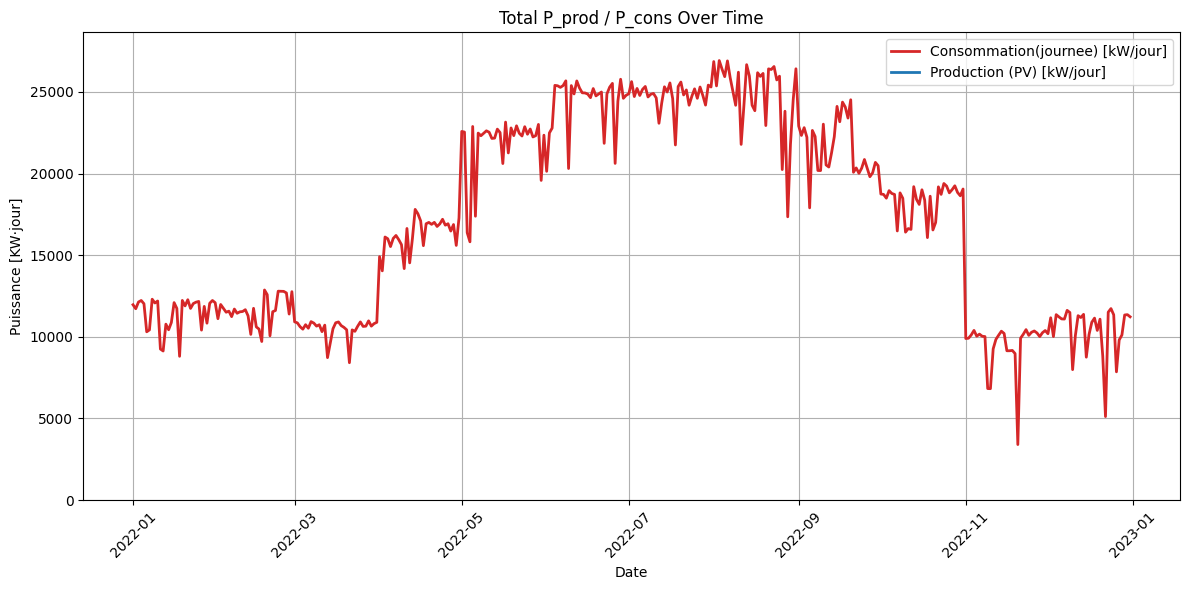

In [34]:
# Convert dictionaries to Series (with datetime indices)
series1 = pd.Series(all_pprod)
series2 = pd.Series(all_pcons)
series3 = pd.Series(all_pprod_grid)
series4 = pd.Series(all_pcons_day)

# Ensure the index is datetime
series1.index = pd.to_datetime(series1.index)
series2.index = pd.to_datetime(series2.index)
series3.index = pd.to_datetime(series3.index)
series4.index = pd.to_datetime(series4.index)

# Resample to daily sums
daily_series1 = series1.resample('D').sum()
daily_series2 = series2.resample('D').sum()
daily_series3 = series3.resample('D').sum()
daily_series4 = series4.resample('D').sum()
# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(daily_series4.index, daily_series4.values, label="Consommation(journee) [kW/jour]", color="tab:red", linewidth=2)
ax.plot(daily_series1.index, daily_series1.values, label="Production (PV) [kW/jour]", color="tab:blue", linewidth=2)
#ax.plot(daily_series2.index, daily_series2.values, label="Consommation [kW/jour]", color="tab:orange", linewidth=2)
#ax.plot(daily_series3.index, daily_series3.values, label="Production (PV+Réseau) [kW/jour]", color="tab:green", linewidth=2)

# Set y-axis to start at 0
ax.set_ylim(bottom=0)

# Format x-axis to show one tick per day with readable dates
#ax.xaxis.set_major_locator(mdates.DayLocator())  # Tick every day
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as 'YYYY-MM-DD'

# Labels and layout
ax.set_xlabel("Date")
ax.set_ylabel("Puissance [KW·jour]")
ax.set_title("Total P_prod / P_cons Over Time")
ax.legend(loc="upper right")
ax.grid(True)

# Improve label spacing
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('prod_cons.png')
plt.show()

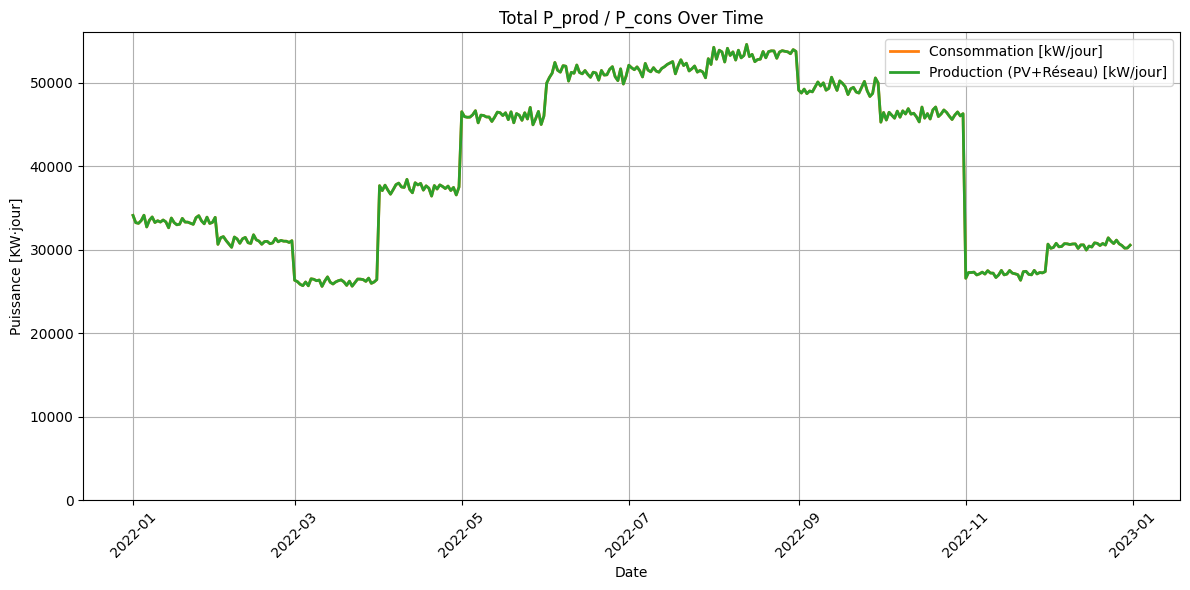

In [35]:
# Convert dictionaries to Series (with datetime indices)
series1 = pd.Series(all_pprod)
series2 = pd.Series(all_pcons)
series3 = pd.Series(all_pprod_grid)
series4 = pd.Series(all_pcons_day)

# Ensure the index is datetime
series1.index = pd.to_datetime(series1.index)
series2.index = pd.to_datetime(series2.index)
series3.index = pd.to_datetime(series3.index)
series4.index = pd.to_datetime(series4.index)

# Resample to daily sums
daily_series1 = series1.resample('D').sum()
daily_series2 = series2.resample('D').sum()
daily_series3 = series3.resample('D').sum()
daily_series4 = series4.resample('D').sum()
# Plot
fig, ax = plt.subplots(figsize=(12, 6))
#ax.plot(daily_series4.index, daily_series4.values, label="Consommation(journee) [kW/jour]", color="tab:red", linewidth=2)
#ax.plot(daily_series1.index, daily_series1.values, label="Production (PV) [kW/jour]", color="tab:blue", linewidth=2)
ax.plot(daily_series2.index, daily_series2.values, label="Consommation [kW/jour]", color="tab:orange", linewidth=2)
ax.plot(daily_series3.index, daily_series3.values, label="Production (PV+Réseau) [kW/jour]", color="tab:green", linewidth=2)

# Set y-axis to start at 0
ax.set_ylim(bottom=0)

# Format x-axis to show one tick per day with readable dates
#ax.xaxis.set_major_locator(mdates.DayLocator())  # Tick every day
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as 'YYYY-MM-DD'

# Labels and layout
ax.set_xlabel("Date")
ax.set_ylabel("Puissance [KW·jour]")
ax.set_title("Total P_prod / P_cons Over Time")
ax.legend(loc="upper right")
ax.grid(True)

# Improve label spacing
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('prod_cons.png')
plt.show()